In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use("classic")
import scipy.optimize as so
from scipy import stats
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import pandas as pd
import pickle

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Text(0.5, 0, '$z$')

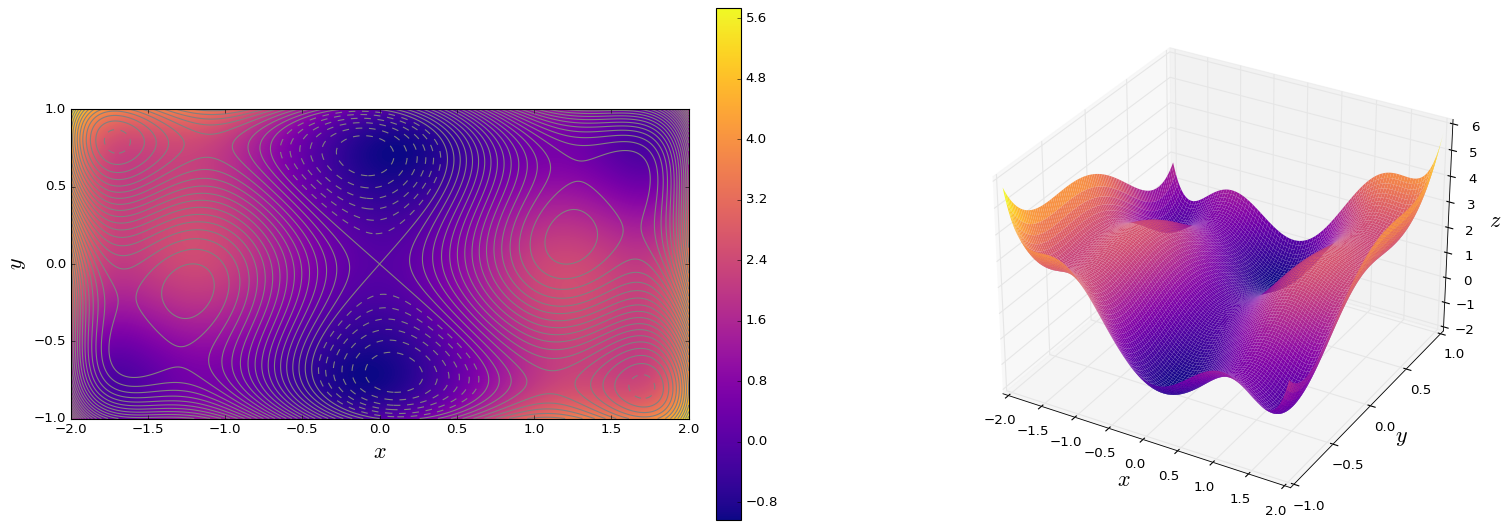

In [48]:
def f(x):
    y = x[1]
    x = x[0]
    f = (4 - 2.1 * x**2 + x**4 / 3) * x**2 + x*y + (4*y**2-4)*y**2
    return f

x = np.linspace(-2, 2, 1000)
y = np.linspace(-1, 1, 1000)

X, Y = np.meshgrid(x, y)
Z = f([X, Y])

fig = plt.figure(); fig.patch.set_facecolor('xkcd:white')
ax = fig.add_subplot(1,2,1); 
plt.rcParams['figure.figsize'] = [24, 12]

img =ax.imshow(Z, cmap = "plasma",extent=[-2, 2, -1, 1])
ax.contour(X, Y, Z, levels = 50, colors = "grey")
fig.colorbar(img, fraction=0.046, pad=0.04)
ax.set_xlabel("$x$", fontsize = 20)
ax.set_ylabel("$y$", fontsize = 20)

# Plot the surface.
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(X, Y, Z, cmap = "plasma", linewidth = 0, antialiased = True)
ax2.set_xlabel("$x$", fontsize = 20)
ax2.set_ylabel("$y$", fontsize = 20)
ax2.set_zlabel("$z$", fontsize = 20)


Checking the previous plots, it can be seen that the function has 6 local minima in the range of study. From the 2d contourplot, it is extracted that the global minima are the two points that nearly on the vertical $x = 0$. Let's find out the exact coordinates of the two points and the function value at these minima:

In [49]:
x0 = [[0.1, -0.75], [-0.1, 0.75], [-1.75, -0.6], [-1.75, 0.8], [1.75, 0.75], [1.75, -0.8]] # introducing a first estimate of the 6 local minima found visually

minima = []
f_min = []
f_gl_min = 2

for estimate in x0:
    minimum = so.minimize(f, estimate, method = "Nelder-Mead")
    if minimum.success:
        minima.append(minimum.x)
        f_min.append(f(minimum.x))
        if f(minimum.x) <= f_gl_min: # appending the first global minimum and getting the function value
            f_gl_min = f(minimum.x)
            gl_min = minimum.x

# checking the second global minimum
for m in minima:
    if np.isclose(f(m), f_gl_min) and any(m != gl_min): # check that the function is taking a different m from the gl_min
        gl_min2 = m

print("The global minima are [%.3f, %.3f], [%.3f, %.3f] and the value of the function at these points is: %1.2f" % (*gl_min, *gl_min2, f_gl_min))

The global minima are [-0.090, 0.713], [0.090, -0.713] and the value of the function at these points is: -1.03


If we now apply the minimization method introducing the $(0,0)$ as an initial guess, we get:

In [50]:
x0 = [0., 0.]

methods = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYLA", "SLSQP", "trust-constr"]

for met in methods:
    minimum = so.minimize(f, x0, method = met)
    if minimum.success:
        print("For method %s, the minimum obtained was [%.3f, %.3f], with a function value of %.3f " % (met, *minimum.x, f(minimum.x)))

For method Nelder-Mead, the minimum obtained was [-0.090, 0.713], with a function value of -1.032 
For method Powell, the minimum obtained was [-0.090, 0.713], with a function value of -1.032 
For method CG, the minimum obtained was [0.000, 0.000], with a function value of 0.000 
For method BFGS, the minimum obtained was [0.000, 0.000], with a function value of 0.000 
For method L-BFGS-B, the minimum obtained was [0.000, 0.000], with a function value of 0.000 
For method TNC, the minimum obtained was [0.000, 0.000], with a function value of 0.000 
For method COBYLA, the minimum obtained was [-0.090, 0.713], with a function value of -1.032 
For method SLSQP, the minimum obtained was [0.000, 0.000], with a function value of 0.000 
For method trust-constr, the minimum obtained was [-0.000, 0.000], with a function value of -0.000 


As we can see above, depending on the method used for optimization, the algorithm converges either to the minimum in $[-0.090,\ 0.713]$, or to the saddle point in $[0,\ 0]$. This instability should be adressed properly studying the way each algorithm is actually built.

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

min:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?


Both temperature distributions have been fitted with sine-like functions with 4 free parameters.


The results for Tmax fit:
T0 = 27.95(43) ºC
Ampl. = 10.58(41) ºC
Freq. = 0.592(21) months^-1
Offset = -8.102(13) months
R^2 =  0.9882502430477917

The results for Tmin fit:
T0 = -36.7(1.2) ºC
Ampl. = 25.1(1.3) ºC
Freq. = 0.601(23) months^-1
Offset = -8.40(14) months
R^2 =  0.9787202745548454


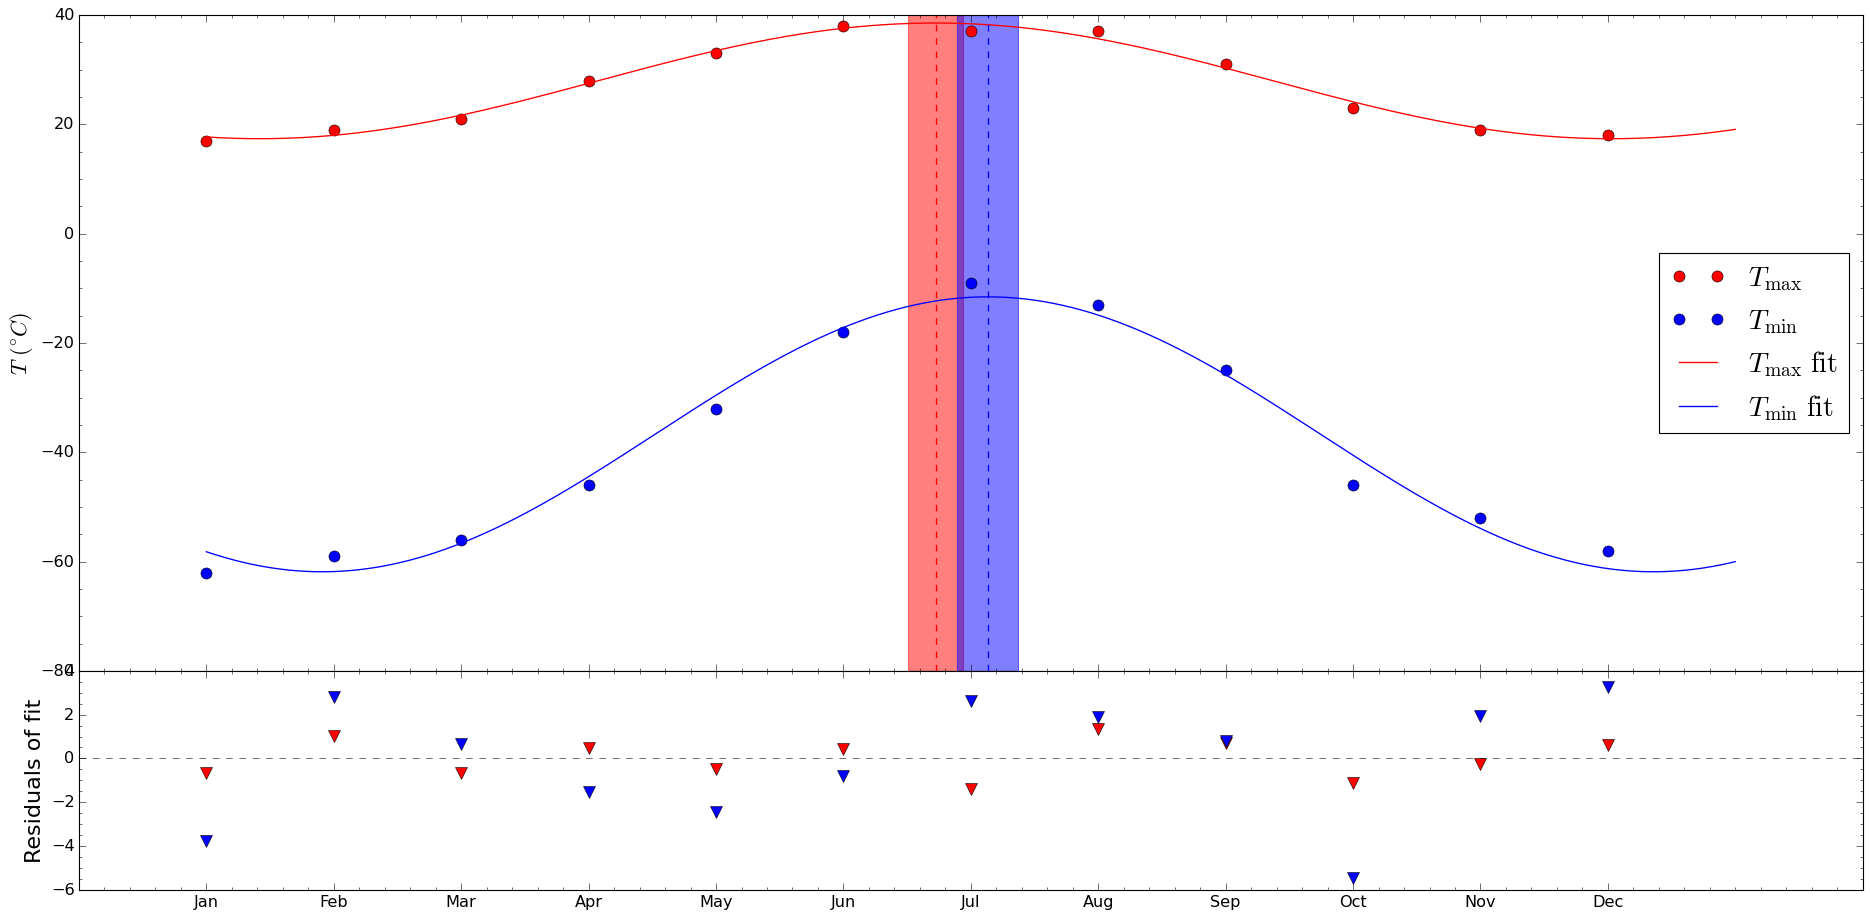

In [3]:
fig, (ax, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}); fig.patch.set_facecolor("xkcd:white")
plt.rcParams['figure.figsize'] = [24, 12]

ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 14.5)
ax.tick_params(axis = 'x', labelbottom = False)
ax.set_xlim(-1, 13)
ax.set_ylabel("$T\ (^{\circ} C)$", fontsize = 20)

ax1.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax1.minorticks_on()
ax1.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax1.tick_params(axis = 'both', labelsize = 14.5)
ax1.set_xlim(-1, 13)
ax1.set_ylabel("Residuals of fit", fontsize = 20)

fig.subplots_adjust(wspace = 0, hspace = 0, top=0.977, right = 0.975, left = 0.046, bottom = 0.066)




Tmax = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
Tmin = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
xfit = np.arange(len(months))

ax.plot(months, Tmax, marker = 'o', markersize = 10, c = 'red', lw = 0, label = "$T_{\max}$")
ax.plot(months, Tmin, marker = 'o', markersize = 10, c = 'blue', lw = 0, label = "$T_{\min}$")



# let us try to fit to a sine-like function

def sine(x, y0, A, w, x0):
    y = y0 + A*np.sin(w*x + x0)
    return y

p0 = [30, 10, 2*np.pi / 12, -6]
sol = so.curve_fit(sine, xfit, Tmax, p0 = p0)
coefmax, cov = sol; y0max, Amax, wmax, x0max = coefmax; xaux = np.linspace(0, 12, 1000); yaux = sine(xaux, *coefmax);
uy0max, uAmax, uwmax, ux0max = np.sqrt(np.diag(cov))
ax.plot(xaux, yaux, color = 'red', linewidth = 1.2, linestyle= 'solid', label = '$T_{\max}\ {\\rm fit}$');

ax.axvline(x = (1 / wmax) * (-3*np.pi / 2 - x0max), color = "red", linestyle = "dashed", linewidth = 1.2)
ax.axvspan((1 / wmax) * (-3*np.pi / 2 - x0max - ux0max), (1 / wmax) * (-3*np.pi / 2 - x0max + ux0max), alpha = 0.5, color = "red")

p0 = [-40, 20, 2*np.pi / 12, -6]
sol = so.curve_fit(sine, xfit, Tmin, p0 = p0)
coefmin, cov = sol; y0min, Amin, wmin, x0min = coefmin; xaux = np.linspace(0, 12, 1000); yaux = sine(xaux, *coefmin);
uy0min, uAmin, uwmin, ux0min = np.sqrt(np.diag(cov))
ax.plot(xaux, yaux, color = 'blue', linewidth = 1.2, linestyle = 'solid', label = '$T_{\min}\ {\\rm fit}$');

ax.axvline(x = (1 / (wmin)) * (-3*np.pi / 2 - x0min), color = "blue", linestyle = "dashed", linewidth = 1.2)
ax.axvspan(1 / wmin * (-3*np.pi / 2 - x0min - ux0min), 1 / wmin * (-3*np.pi / 2 - x0min + ux0min), alpha = 0.5, color = "blue")

ax.legend(loc = "best", fontsize = 25)


# RESIDUALS
res_max = Tmax - sine(xfit, *coefmax)
ss_res = sum(res_max**2)
ss_tot = sum((Tmax-np.mean(Tmax))**2)
r_squared_max = 1 - (ss_res / ss_tot)

res_min = Tmin - sine(xfit, *coefmin)
ss_res = sum(res_min**2)
ss_tot = sum((Tmin-np.mean(Tmin))**2)
r_squared_min = 1 - (ss_res / ss_tot)



ax1.plot(months, res_max, marker = 'v', markersize = 10, c = 'red', lw = 0., label = "${\\rm res}_{\max}$")
ax1.plot(months, res_min, marker = 'v', markersize = 10, c = 'blue', lw = 0., label = "${\\rm res}_{\min}$")
ax1.axhline(y = 0, color = "black", linestyle = "dashed", lw = 0.5)


print("\nBoth temperature distributions have been fitted with sine-like functions with 4 free parameters.\n")
print("=======")
print("\nThe results for Tmax fit:")
print("T0 = %.2f(%2.0f) ºC" % (y0max, uy0max*100))
print("Ampl. = %.2f(%2.0f) ºC" % (Amax, uAmax*100))
print("Freq. = %.3f(%2.0f) months^-1" % (wmax, uwmax*1000))
print("Offset = %.3f(%2.0f) months" % (x0max, ux0max*100))
print("R^2 = ", r_squared_max)

print("\nThe results for Tmin fit:")
print("T0 = %.1f(%1.1f) ºC" % (y0min, uy0min))
print("Ampl. = %1.1f(%1.1f) ºC" % (Amin, uAmin))
print("Freq. = %.3f(%2.0f) months^-1" % (wmin, uwmin*1000))
print("Offset = %.2f(%2.0f) months" % (x0min, ux0min*100))
print("R^2 = ", r_squared_min)

As it can be seen from the graphs and the results presented above, both fits have reasonably good quality ($R^{2}$ values very close to 1), and the sine-like function implements an aspect that we would naturally expect from temperature distributions from year to year: periodicity. However, it is very unlikely that we obtain a good fit using only one year as a sample, so bearing that in mind, the results are reasonably good.

In [4]:
offset = np.abs((1 / wmax) * (-3*np.pi / 2 - x0max) - (1 / wmin) * (-3*np.pi / 2 - x0min))
print("The time offset is: ", offset)

The time offset is:  0.4102209785891189


The time offset corresponds approximately to half a month and, if we draw the region defined by the uncertainties in these offsets, we can see that there is some overlap in the middle and it can therefore be concluded than the maxima for minimum an maximum temperatures are the same within the fit accuracy.

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?


The results for the fit:
a = 11.35(42)
b = -4.01(26)
Ampl. = 580.3(8.2)
mean = -0.0885(27)
sigma = 0.2445(24)


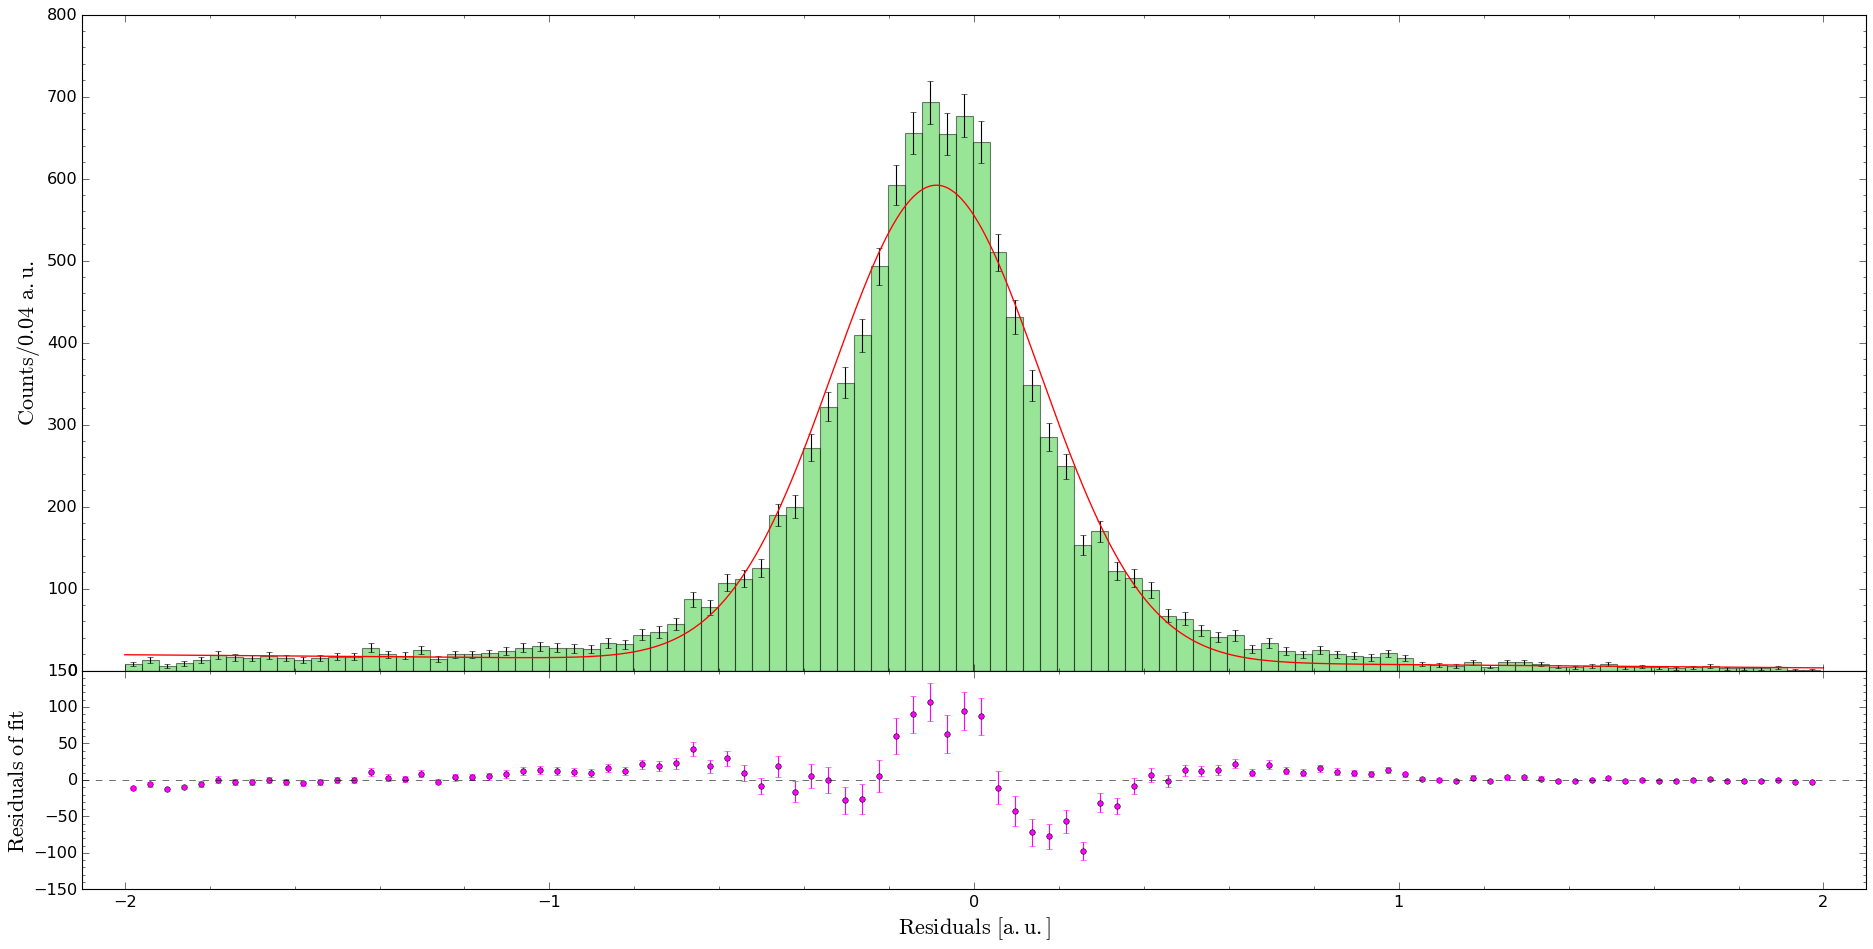

In [5]:
def fun(x, a, b, A, mu, sigma):
    '''
        definition of gaussian function + linear background function
    '''
    y = A * np.exp( - (x - mu) ** 2 / (2 * sigma ** 2) ) + a + b * x
    return y

def chi_squared(x, y_experimental, uy_experimental, fun, coef):
    y_fit = fun(x, *coef)
    suma_desv = 0
    residuals = np.zeros(len(y_experimental))
    for i in range(len(x)-1):
        residuals[i] = y_experimental[i]-y_fit[i]
        suma_desv += residuals[i]**2/(uy_experimental[i])**2
    chi2_red = suma_desv/(len(x)-len(coef))
    return residuals, suma_desv, chi2_red

# reading
filename = "data/residuals_261.pkl"
infile = open(filename, 'rb')
df = pd.DataFrame(dict(pickle.load(infile).item()))

# clean data
res = df["residuals"].loc[np.abs(df["residuals"]) < 2]

fig, (ax, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}); fig.patch.set_facecolor("xkcd:white")
plt.rcParams['figure.figsize'] = [24, 12]


ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 14.5)
ax.tick_params(axis = 'x', labelbottom = False)

nbins = 100
#nbins = int(1 + 3.322*np.log(len(res))) # sturge's rule
h, bin_edges, _ = ax.hist(res, bins = nbins, alpha = .5, color = "limegreen")
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
poisson_sigma = np.sqrt(h)

ax.set_xlim(-2.1, 2.1)
ax.set_ylabel("${\\rm Counts}/%1.2f\ \mathrm{a.u.}$" % (bin_edges[1]-bin_edges[0]), size = 20)
ax.errorbar(bin_centers, h, yerr = poisson_sigma, capsize = 3., elinewidth = 1., lw = 0, color = "black")


p0 = [10, -1, 600, -0.1, 0.2]
sol = so.curve_fit(fun, bin_centers, h, p0 = p0, sigma = poisson_sigma, absolute_sigma = True)
coef, cov = sol; a, b, A, mu, sigma = coef; xaux = np.linspace(-2, 2, 1000); yaux = fun(xaux, *coef);
ua, ub, uA, umu, usigma = np.sqrt(np.diag(cov))

ax.plot(xaux, yaux, color = 'red', linewidth = 1.2, linestyle= 'solid')

print("\nThe results for the fit:")
print("a = %2.2f(%2.0f)" % (a, ua*100))
print("b = %2.2f(%2.0f)" % (b, ub*100))
print("Ampl. = %3.1f(%1.1f)" % (A, uA))
print("mean = %.4f(%2.0f)" % (mu, umu*1e4))
print("sigma = %.4f(%2.0f)" % (sigma, usigma*1e4))



# RESIDUALS

ax1.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax1.minorticks_on()
ax1.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax1.tick_params(axis = 'both', labelsize = 14.5)

ax1.set_xlim(-2.1, 2.1)
ax1.set_xlabel("${\\rm Residuals}\ [\mathrm{a.u.}]$", fontsize = 20); ax1.set_ylabel("${\\rm Residuals\ of\ fit}$", fontsize = 20)

# residuals calculation
res, chi_sq, chi_sq_red = chi_squared(bin_edges, h, poisson_sigma, fun, coef)
ax1.plot(bin_centers, res, marker = 'o', markersize = 5, c = "magenta", lw = 0,)
ax1.errorbar(bin_centers, res, yerr = poisson_sigma, capsize = 3., elinewidth = 1., lw = 0, color = "magenta")
ax1.axhline(y = 0, color = "black", linestyle = "dashed", lw = 0.5)

fig.subplots_adjust(wspace = 0, hspace = 0, top=0.977, right = 0.975, left = 0.046, bottom = 0.066)


In [6]:
p_value = 1 - stats.chi2.cdf(chi_sq, df = nbins - len(coef), loc = 0, scale = 2)
print("\nThe chi2 of the fit is: ", chi_sq)
print("And the corresponding p-value: ", p_value)


The chi2 of the fit is:  497.57678186493064
And the corresponding p-value:  9.992007221626409e-16


As reported above, the probability of obtaining a fit at least as bad as the one obtained is nearly 0 ($\sim 10^{-16}$). We can therefore conclude that the fit was not satisfactory with regard to this p-value.

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

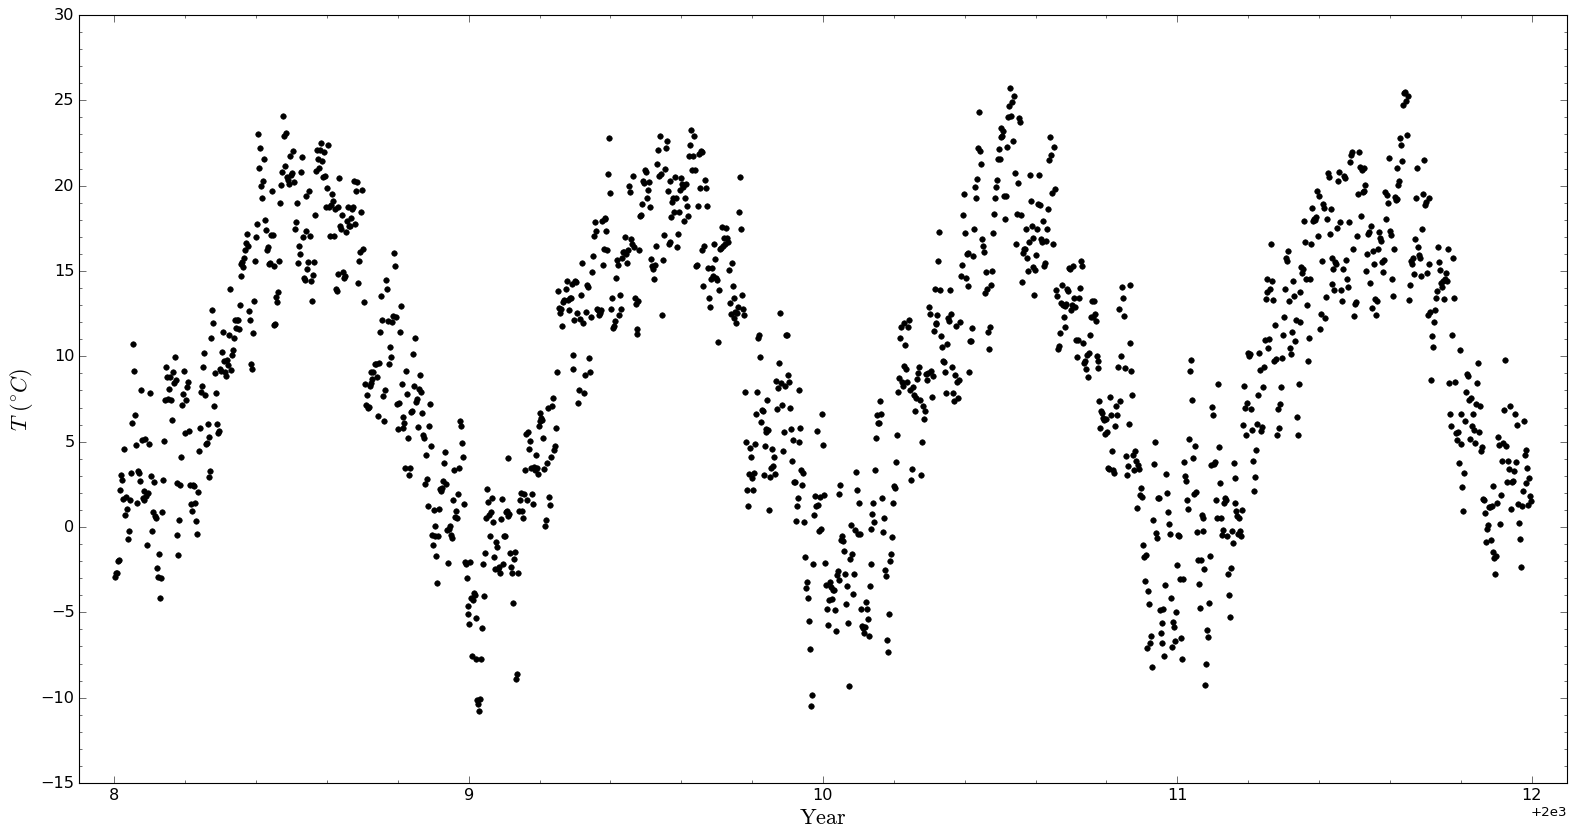

In [9]:
def f(t, a, b, c):
	return a * np.cos(2 * np.pi * t + b) + c

filename = "data/munich_temperatures_average_with_bad_data.txt"

year = []
T = []

# reading
data = open(filename, 'r').read().split('\n')
for j in range(len(data)):
    contains_digit = any(map(str.isdigit, data[j])) # analyzing if the line contains data
    if contains_digit == True:
        par = data[j].split(' ')
        year.append(float(par[0]))
        T.append(float(par[1]))
year = np.array(year)
T = np.array(T)

# cleaning the bad data and selecting the proper range
year = year[np.abs(T)<40]
T = T[np.abs(T)<40]

T = T[year > 2008]
year = year[year > 2008]
T = T[year < 2012]
year = year[year < 2012]

fig, ax = plt.subplots(); fig.patch.set_facecolor("xkcd:white")
plt.rcParams['figure.figsize'] = [24, 8]

ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 14.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel("${\\rm Year}$", fontsize = 20); ax.set_ylabel("$T\ (^{\circ} C)$", fontsize = 20)
ax.set_xlim(2007.9, 2012.1)

ax.plot(year, T, marker = 'o', markersize = 5, c = 'black', lw = 0, label = "${\\rm Data}$")

##### What are the best-fit values of the parameters?


The best fit-values of the parameters are
a = -9.96(13)
b = -0.235(13)
c = 9.263(94)


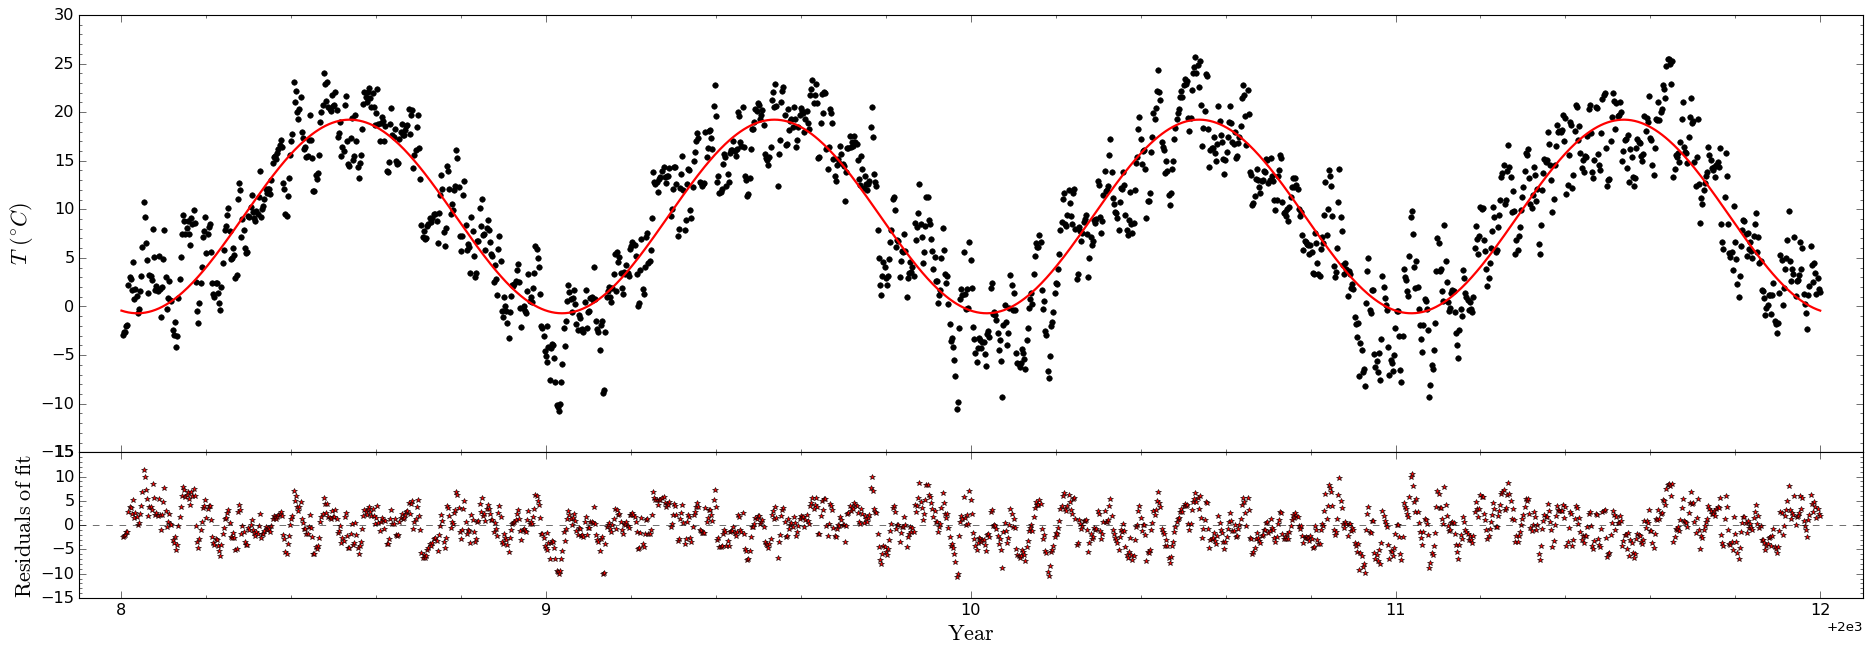

In [10]:
p0 = [10, 0, 8]
sol = so.curve_fit(f, year, T, p0 = p0)
coef, cov = sol; a, b, c = coef; xaux = np.linspace(2008, 2012, 1000); yaux = f(xaux, *coef);
ua, ub, uc = np.sqrt(np.diag(cov))

fig, (ax, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}); fig.patch.set_facecolor("xkcd:white")
plt.rcParams['figure.figsize'] = [24, 12]

ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 14.5)
ax.tick_params(axis = 'x', labelbottom = False)
ax.set_ylabel("$T\ (^{\circ} C)$", fontsize = 20)
ax.set_xlim(2007.9, 2012.1)

ax1.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax1.minorticks_on()
ax1.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax1.tick_params(axis = 'both', labelsize = 14.5)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlim(2007.9, 2012.1)
ax1.set_xlabel("${\\rm Year}$", fontsize = 20); ax1.set_ylabel("${\\rm Residuals\ of\ fit}$", fontsize = 20)

ax.plot(year, T, marker = 'o', markersize = 5, c = 'black', lw = 0, label = "${\\rm Data}$")
ax.plot(xaux, yaux, color = "red", linewidth = 2., linestyle= 'solid')

print("\nThe best fit-values of the parameters are")
print("a = %2.2f(%2.0f)" % (a, ua*100))
print("b = %2.3f(%2.0f)" % (b, ub*1000))
print("c = %2.3f(%2.0f)" % (c, uc*1000))



# RESIDUALS

res = T - f(year, *coef)
ss_res_f = sum(res**2)
ss_tot = sum((T-np.mean(T))**2)
r_squared = 1 - (ss_res_f / ss_tot)



ax1.plot(year, res, marker = '*', markersize = 5, c = 'red', lw = 0)
ax1.axhline(y = 0, color = "black", linestyle = "dashed", lw = 0.5)
fig.subplots_adjust(wspace = 0, hspace = 0, top=0.977, right = 0.975, left = 0.046, bottom = 0.066)


The overall average value of the temperature in Münich can be interpreted as the parameter $c$, and can be therefore expected to be $\bar{T} = 9.263(94)\textrm{ }\mathrm{^{\circ}C}$. The typical daily average values predicted by the model for the coldest and hottest times of the year can be interpreted as the amplitude of the cosine added to $c$, which in our case results in:

$$ T^{\max} = |a| + c = 19.22(16) \textrm{ }\mathrm{^{\circ}C}\ ; \qquad T^{\min} = -|a| + c = -0.70(16) \textrm{ }\mathrm{^{\circ}C}.$$

The $b$ parameter has the meaning of a sine phase, in this case to account for the offset produced by $2 \pi t$ once the temperature at a given time is fixed. It has no physical meaning  but rather mathematical, to make maximum/minimum temperatures coincide with maximum/minimum values of the cosine function.


The best fit-values of the parameters are
a = 9.96(13)
b = 1.0003(19)
c = -1(24)
d = 9.27(10)


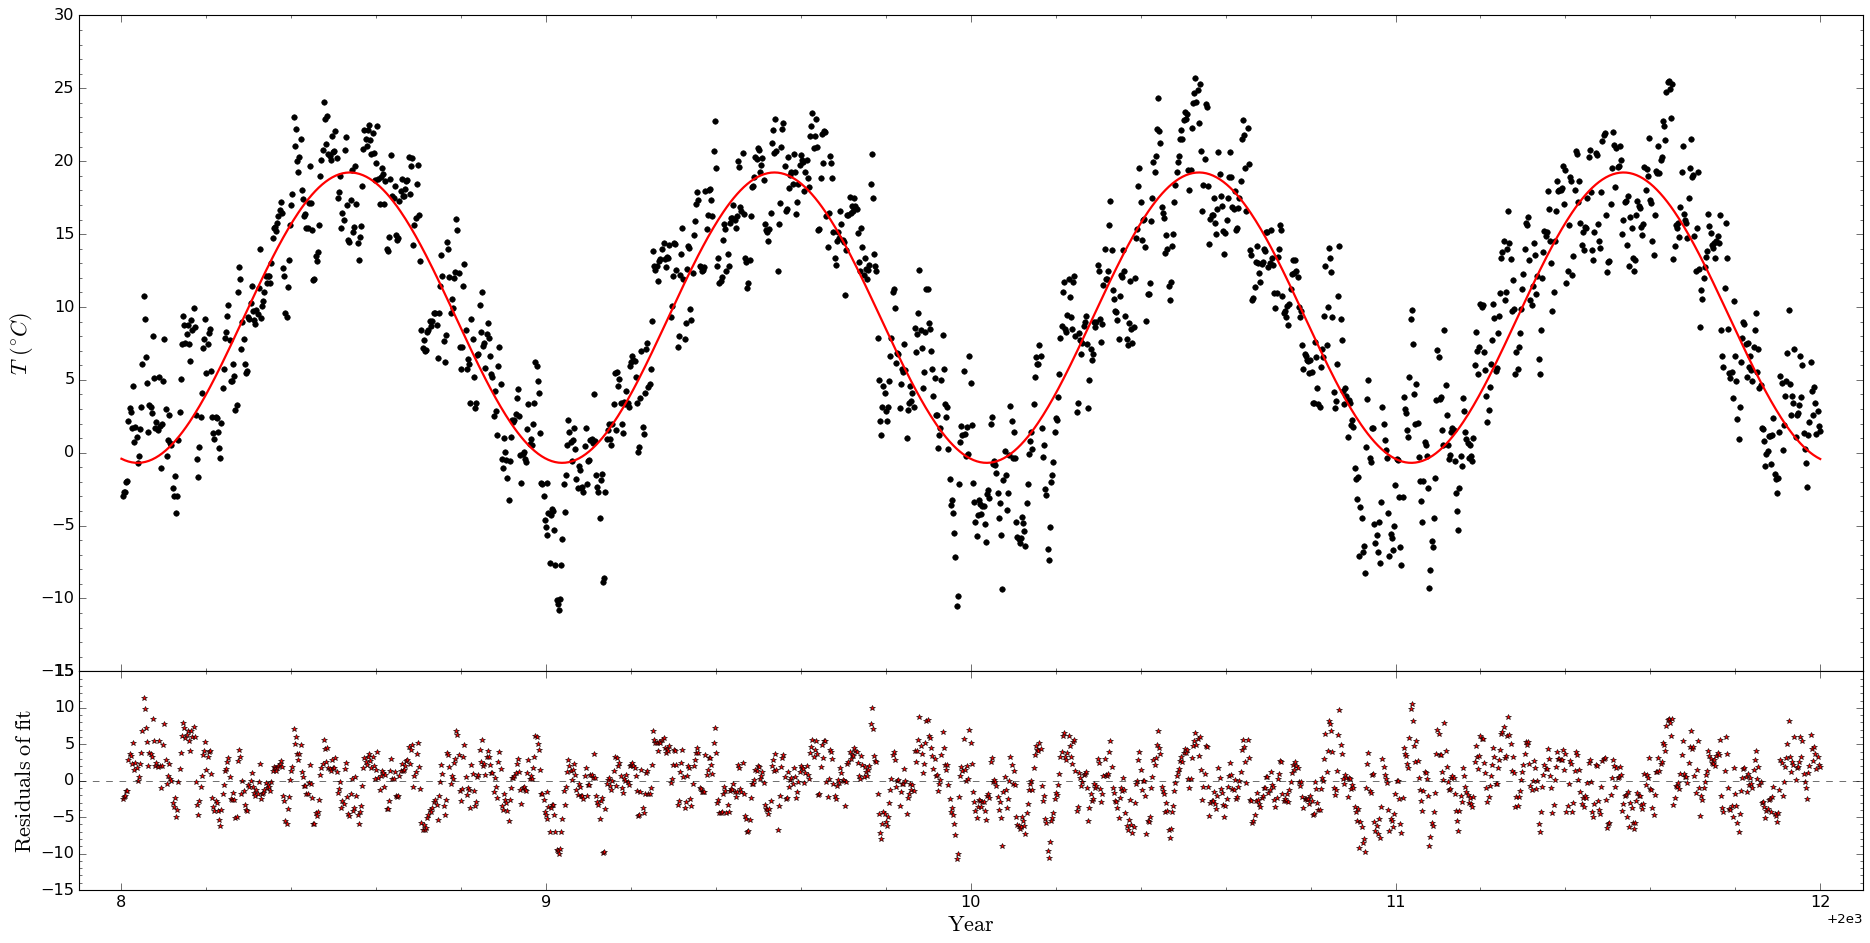

In [11]:
def g(t, a, b, c, d):
	return a * np.cos(2 * np.pi * b * t + c) + d


fig, (ax, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}); fig.patch.set_facecolor("xkcd:white")
plt.rcParams['figure.figsize'] = [24, 12]

ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 14.5)
ax.tick_params(axis = 'x', labelbottom = False)
ax.set_ylabel("$T\ (^{\circ} C)$", fontsize = 20)
ax.set_xlim(2007.9, 2012.1)

ax1.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax1.minorticks_on()
ax1.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax1.tick_params(axis = 'both', labelsize = 14.5)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlim(2007.9, 2012.1)
ax1.set_xlabel("${\\rm Year}$", fontsize = 20); ax1.set_ylabel("${\\rm Residuals\ of\ fit}$", fontsize = 20)




p0 = [15, 1, 3.1, 9]
sol = so.curve_fit(g, year, T, p0 = p0)
coef, cov = sol; a, b, c, d = coef; xaux = np.linspace(2008, 2012, 1000); yaux = g(xaux, *coef);
ua, ub, uc, ud = np.sqrt(np.diag(cov))

print("\nThe best fit-values of the parameters are")
print("a = %2.2f(%2.0f)" % (a, ua*100))
print("b = %2.4f(%2.0f)" % (b, ub*1e4))
print("c = %2.0f(%2.0f)" % (c, uc))
print("d = %2.2f(%2.0f)" % (d, ud*100))

ax.plot(year, T, marker = 'o', markersize = 5, c = 'black', lw = 0, label = "${\\rm Data}$")
ax.plot(xaux, yaux, color = "red", linewidth = 2., linestyle= 'solid')


# RESIDUALS

res_g = T - g(year, *coef)
ss_res_g = sum(res_g**2)
ss_tot = sum((T-np.mean(T))**2)
r_squared = 1 - (ss_res_g / ss_tot)


ax1.plot(year, res_g, marker = '*', markersize = 5, c = 'red', lw = 0)
ax1.axhline(y = 0, color = "black", linestyle = "dashed", lw = 0.5)
fig.subplots_adjust(wspace = 0, hspace = 0, top=0.977, right = 0.975, left = 0.046, bottom = 0.066)

In [12]:
print("\nThe SSR for the fit with function f is: ", ss_res_f)
print("The SSR for the fit with function g is: ", ss_res_g)

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

CL = Ftest(ss_res_f, ss_res_g, 3, 4, len(year), verbose = True)


The SSR for the fit with function f is:  18669.51539457837
The SSR for the fit with function g is:  18669.22543081297
CL: 0.881 , additional parameter necessary: NO
